# Sentiment classification - close to the state of the art

The task of classifying sentiments of texts (for example movie or product reviews) has high practical significance in online marketing as well as financial prediction. This is a non-trivial task, since the concept of sentiment is not easily captured.

For this assignment you have to use the larger [IMDB sentiment](https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz) benchmark dataset from Stanford, an achieve close to state of the art results.

The task is to try out multiple models in ascending complexity, namely:

1. TFIDF + classical statistical model (eg. RandomForest)
2. LSTM classification model
3. LSTM model, where the embeddings are initialized with pre-trained GloVe vectors
4. fastText model
5. BERT based model (you are advised to use a pre-trained one and finetune, since the resource consumption is considerable!)

You should get over 90% validation accuracy (though nearly 94 is achievable).

You are allowed to use any library or tool, though the Keras environment, and some wrappers on top (ie. Ktrain) make your life easier.





__Groups__
This assignment is to be completed individually, two weeks after the class has finished. For the precise deadline please see canvas.

__Format of submission__
You need to submit a pdf of your Google Collab notebooks.

__Due date__
Two weeks after the class has finished. For the precise deadline please see canvas.

Grade distribution:
1. TFIDF + classical statistical model (eg. RandomForest) (25% of the final grade)
2. LSTM classification model (15% of the final grade)
3. LSTM model, where the embeddings are initialized with pre-trained GloVe vectors (15% of the final grade)
4. fastText model (15% of the final grade)
5. BERT based model (you are advised to use a pre-trained one and finetune it, since the resource consumption is considerable!) (30% of the final grade). For BERT you should get over 90% validation accuracy (though nearly 94% is achievable).


__For each of the models, the marks will be awarded according to the following three criteria__:

(1) The (appropriately measured) accuracy of your prediction for the task. The more accurate the prediction is, the better. Note that you need to validate the predictive accuracy of your model on a hold-out of unseen data that the model has not been trained with.

(2) How well you motivate the use of the model - what in this model's structure makes it suited for representing sentiment? After using the model for the task how well you evaluate the accuracy you got for each model and discuss the main advantages and disadvantages the model has in the particular modelling task. At best you take part of the modelling to support your arguments.

(3) The consistency of your take-aways, i.e. what you have learned from your analyses. Also, analyze when the model is good and when and where it does not predict well.

Please make sure that you comment with # on the separates steps of the code you have produced. For the verbal description and analyses plesae insert markdown cells.


__Plagiarism__: The Frankfurt School does not accept any plagiarism. Data science is a collaborative exercise and you can discuss the research question with your classmates from other groups, if you like. You must not copy any code or text though. Plagiarism will be prosecuted and will result in a mark of 0 and you failing this class.

After carefully reading this document and having had a look at the data you may still have questions. Please submit those question to the public Q&A board in canvas and we will answer each question, so 

In [0]:
!wget https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xzf aclImdb_v1.tar.gz
!ls

--2019-12-12 19:46:03--  https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  15.5MB/s    in 14s     

2019-12-12 19:46:17 (5.88 MB/s) - ‘aclImdb_v1.tar.gz’ saved [84125825/84125825]

aclImdb  aclImdb_v1.tar.gz  sample_data


### Libraries Imports

In [0]:
%%capture
!python -m spacy download en_core_web_sm
!pip install spacy gensim pprint
!pip install pyldavis wordcloud bokeh

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from glob import glob
import numpy as np
import os,re,string,spacy
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from matplotlib import pyplot as plt
from wordcloud import WordCloud
import matplotlib.colors as mcolors

Look and preparing the data

In [0]:
data = '/content/aclImdb'
names = ['neg','pos']
!ls {data}
!ls {data}/train
!ls {data}/train/pos | head

#Similar for the test folder
!ls {data}/test
!ls {data}/test/pos | head

imdbEr.txt  imdb.vocab	README	test  train
labeledBow.feat  pos	unsupBow.feat  urls_pos.txt
neg		 unsup	urls_neg.txt   urls_unsup.txt
0_9.txt
10000_8.txt
10001_10.txt
10002_7.txt
10003_8.txt
10004_8.txt
10005_7.txt
10006_7.txt
10007_7.txt
10008_7.txt
labeledBow.feat  neg  pos  urls_neg.txt  urls_pos.txt
0_10.txt
10000_7.txt
10001_9.txt
10002_8.txt
10003_8.txt
10004_9.txt
10005_8.txt
10006_7.txt
10007_10.txt
10008_8.txt


In [0]:
def load_texts_labels_from_folders(path, folders):
    texts,labels = [],[]
    for idx,label in enumerate(folders):
        for fname in glob(os.path.join(path, label, '*.*')):
            texts.append(open(fname, 'r').read())
            labels.append(idx)
    # stored as np.int8 to save space 
    return texts, np.array(labels).astype(np.int8)


In [0]:
trn,trn_y = load_texts_labels_from_folders(f'{data}/train',names)
val,val_y = load_texts_labels_from_folders(f'{data}/test',names)

In [0]:
len(trn),len(trn_y),len(val),len(val_y)

(25000, 25000, 25000, 25000)

In [0]:
len(trn_y[trn_y==1]),len(val_y[val_y==1])

(12500, 12500)

In [0]:
np.unique(trn_y)

array([0, 1], dtype=int8)

In [0]:
print(trn[-1])
print()
print(f"Review's label: {trn_y[-1]}")

First things first, Edison Chen did a fantastic, believable job as a Cambodian hit-man, born and bred in the dumps and a gladiatorial ring, where he honed his craft of savage battery in order to survive, living on the mantra of kill or be killed. In a role that had little dialogue, or at least a few lines in Cambodian/Thai, his performance is compelling, probably what should have been in the Jet Li vehicle Danny the Dog, where a man is bred for the sole purpose of fighting, and on someone else's leash.<br /><br />Like Danny the Dog, the much talked about bare knuckle fight sequences are not choreographed stylistically, but rather designed as normal, brutal fisticuffs, where everything goes. This probably brought a sense of realism and grit when you see the characters slug it out at each other's throats, in defending their own lives while taking it away from others. It's a grim, gritty and dark movie both literally and figuratively, and this sets it apart from the usual run off the mill

In [0]:
def read_text_file(path):
    """
    Read and return all the contents of the text-file with the given path.
    It is returned as a single string where all lines are concatenated.
    """

    with open(path, 'rt', encoding='utf-8') as file:
        # Read a list of strings.
        lines = file.readlines()

        # Concatenate to a single string.
        text = " ".join(lines)

    return text

In [0]:
read_text_file('/content/aclImdb/test/neg/10000_4.txt')

"This is an example of why the majority of action films are the same. Generic and boring, there's really nothing worth watching here. A complete waste of the then barely-tapped talents of Ice-T and Ice Cube, who've each proven many times over that they are capable of acting, and acting well. Don't bother with this one, go see New Jack City, Ricochet or watch New York Undercover for Ice-T, or Boyz n the Hood, Higher Learning or Friday for Ice Cube and see the real deal. Ice-T's horribly cliched dialogue alone makes this film grate at the teeth, and I'm still wondering what the heck Bill Paxton was doing in this film? And why the heck does he always play the exact same character? From Aliens onward, every film I've seen with Bill Paxton has him playing the exact same irritating character, and at least in Aliens his character died, which made it somewhat gratifying...<br /><br />Overall, this is second-rate action trash. There are countless better films to see, and if you really want to s

In [0]:
df = pd.read_csv('/content/aclImdb/test/neg/10000_4.txt')
print(df)

Empty DataFrame
Columns: [This is an example of why the majority of action films are the same. Generic and boring,  there's really nothing worth watching here. A complete waste of the then barely-tapped talents of Ice-T and Ice Cube,  who've each proven many times over that they are capable of acting,  and acting well. Don't bother with this one,  go see New Jack City,  Ricochet or watch New York Undercover for Ice-T,  or Boyz n the Hood,  Higher Learning or Friday for Ice Cube and see the real deal. Ice-T's horribly cliched dialogue alone makes this film grate at the teeth,  and I'm still wondering what the heck Bill Paxton was doing in this film? And why the heck does he always play the exact same character? From Aliens onward,  every film I've seen with Bill Paxton has him playing the exact same irritating character,  and at least in Aliens his character died,  which made it somewhat gratifying...<br /><br />Overall,  this is second-rate action trash. There are countless better film

### TFIDF + classical statistical model (eg. RandomForest)

#### import depencies for model

Tokenize data

In [0]:
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize(s): 
  return re_tok.sub(r' \1 ', s).split()

In [0]:
#create term document matrix
veczr = CountVectorizer(tokenizer=tokenize)

In [0]:
print(veczr)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=<function tokenize at 0x7fb09a873598>,
                vocabulary=None)


In [0]:
tokenize(trn[13000])

['No',
 'one',
 'would',
 'argue',
 'that',
 'this',
 '1945',
 'war',
 'film',
 'was',
 'a',
 'masterpiece',
 '.',
 '(',
 'How',
 'could',
 'any',
 '1945',
 'war',
 'film',
 'be',
 'a',
 'masterpiece',
 '?',
 ')',
 'And',
 'yet',
 'this',
 'is',
 'an',
 'extremely',
 'effective',
 'telling',
 'of',
 'a',
 'true',
 'story',
 ',',
 'that',
 'of',
 'Al',
 'Schmidt',
 ',',
 'blinded',
 'on',
 'Guadalcanal',
 ',',
 'as',
 'played',
 'by',
 'John',
 'Garfield',
 ',',
 'who',
 'spent',
 'days',
 'wearing',
 'a',
 'blindfold',
 'to',
 'capture',
 'the',
 'nuances',
 'of',
 'a',
 'blind',
 'person',
 "'",
 's',
 'actions',
 '.',
 'Robert',
 'Leckie',
 ',',
 'in',
 '"',
 'Helmet',
 'for',
 'My',
 'Pillow',
 '"',
 ',',
 'denigrates',
 'Schmidt',
 "'",
 's',
 'popularity',
 'in',
 'favor',
 'of',
 'his',
 'foxhole',
 'mate',
 ',',
 'who',
 'was',
 'killed',
 ',',
 'writing',
 'that',
 '"',
 'the',
 'country',
 'must',
 'have',
 'needed',
 'live',
 'heroes',
 '.',
 '"',
 '<',
 'br',
 '/',
 '>',
 '<

In [0]:
trn_term_doc = veczr.fit_transform(trn)
# Important: Use same vocab for validation set
val_term_doc = veczr.transform(val)

In [0]:
veczr = CountVectorizer(tokenizer=tokenize,ngram_range=(1,3), max_features=80000,)

In [0]:
trn_term_doc[5] #83 stored elements

<1x75132 sparse matrix of type '<class 'numpy.int64'>'
	with 139 stored elements in Compressed Sparse Row format>

In [0]:
w0 = set([o.lower() for o in trn[5].split(' ')]); w0


{'-',
 '/><br',
 '/>acting',
 '/>directing',
 '/>it',
 '/>plot',
 '/>scrip',
 '/>special',
 '10',
 '<br',
 'a',
 'ability',
 'abomination',
 'accidentally',
 'act',
 'acting.<br',
 'an',
 'and',
 'any',
 'as',
 'at',
 'bad',
 'be',
 'been',
 'being',
 'best',
 'broke',
 'bus',
 'but',
 'by',
 'can',
 'character',
 'characters',
 'chinese',
 'clear',
 'come',
 'computer',
 'considered',
 'constantly',
 'copy',
 'could',
 'degree',
 'did',
 'directer',
 'directing',
 'disappointed.<br',
 'down',
 'effects',
 'entire',
 'even',
 'extras',
 'failed',
 'failures',
 'faster',
 'favorite',
 'flow',
 'for',
 'friends/family',
 'generous',
 'get',
 'giving',
 'good',
 'got',
 'had',
 'hard',
 'have',
 'his',
 'i',
 'ignore',
 'imbecilic.',
 'in',
 'interesting',
 'is',
 'it',
 'it.',
 'knock',
 'know',
 'letting',
 'like',
 'lines',
 'majority',
 'make',
 'managed',
 'many',
 'memorable.',
 'memorable.<br',
 'more',
 'movie',
 'movies',
 'nature.',
 'no',
 'not',
 'now',
 'of',
 'off',
 'only',

In [0]:
len(w0)

142

In [0]:
vocab = veczr.get_feature_names()
print(len(vocab))
vocab[5000:5005]

NotFittedError: ignored

### LSTM classification model

#### depencies imports

In [0]:
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Model
from keras import backend as K
from tensorflow.keras import Sequential

In [0]:
lstm_size1 = 400

In [0]:
# Loss
loss = 'sparse_categorical_crossentropy' # Our output is One-hot encoded. What do w
e use?
# Optimizer
optimizer = 'Nadam' # According to taste...
# Compilation
#############
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

In [0]:
#fitting model
model.fit(data_x,data_y,validation_split=0.1,batch_size=100,epochs=8)

### LSTM model, where the embeddings are initialized with pre-trained GloVe vectors

In [0]:
from keras.layers.embeddings import Embedding

In [0]:
lstm_size2 = 400
embedding_size = 325

In [0]:
# Loss
loss = 'sparse_categorical_crossentropy' # Our output is One-hot encoded. What do w
e use?
# Optimizer
optimizer = 'Nadam' # According to taste...
# Compilation
#############
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

In [0]:
#fitting model
model.fit(data_x,data_y,validation_split=0.1,batch_size=100,epochs=8)

#### import dependencies for fasttext model and BERT model

In [0]:
%%capture
!pip install ktrain
!pip install fasttext

In [0]:
%tensorflow_version 2.x
import ktrain
from ktrain import text
from keras.preprocessing.text import Tokenizer
from gensim.models.fasttext import FastText
import numpy as np
import matplotlib.pyplot as plt
import nltk
from string import punctuation
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize
from nltk import WordPunctTokenizer
import fasttext as ft

TensorFlow 2.x selected.
using Keras version: 2.2.4-tf


### fastText model

#### data preperation for model

In [0]:
(x_train, y_train), (x_test, y_test), preproc = text.texts_from_folder('/content/aclImdb',
                                                                       maxlen=500,
                                                                       preprocess_mode='fasttext',
                                                                       classes=['pos','neg']
                                                                      )

detected encoding: utf-8


TypeError: ignored

In [0]:
modelfasttext = ft.train_supervised(trn[13000])

In [0]:
print(trn_term_doc)

In [0]:
modelfasttext.predict('/content/aclImdb/test/neg/10000_4.txt',k=2)

### BERT based model (you are advised to use a pre-trained one and finetune, since the resource consumption is considerable!)

#### importing dependencies for model

#### data preparation

In [0]:
(x_train, y_train), (x_test, y_test), preproc = text.texts_from_folder('/content/aclImdb',
                                                                       maxlen=500,
                                                                       preprocess_mode='bert',
                                                                       classes=['pos','neg']
                                                                      )

detected encoding: utf-8
downloading pretrained BERT model (uncased_L-12_H-768_A-12.zip)...
[██████████████████████████████████████████████████]
extracting pretrained BERT model...
done.

cleanup downloaded zip...
done.

preprocessing train...
language: en


preprocessing test...
language: en


In [0]:
learner = ktrain.get_learner(text.text_classifier('bert',(x_train,y_train),preproc=preproc),
                                                train_data=(x_train,y_train),
                                                val_data=(x_test, y_test),
                                                batch_size=5)

Is Multi-Label? False
maxlen is 500
done.


simulating training for different learning rates... this may take a few moments...
Train on 25000 samples
Epoch 1/1024
 5730/25000 [=====>........................] - ETA: 26:43 - loss: 0.7035 - acc: 0.6433

done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


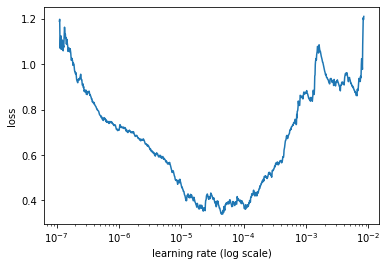

In [0]:
learner.lr_find()
learner.lr_plot()

In [0]:
learner.fit_onecycle(2e-5, 3)



begin training using onecycle policy with max lr of 2e-05...
Train on 25000 samples, validate on 25000 samples
Epoch 1/3
24995/25000 [============================>.] - ETA: 0s - loss: 0.2578 - acc: 0.8954

In [0]:
learner.view_top_losses(n=1, preproc=preproc)